# Data Preprocessing Stage 2
This notebook will handle aggregating external datasets.

In [1]:
# Initialise a spark session
import pandas as pd
from collections import Counter
import os
from pyspark.sql import SparkSession
from pyspark.sql import functions as F


spark = (
    SparkSession.builder.appName("Data Processing 2")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "8g")  # Increase driver memory
    .config("spark.executor.memory", "8g")  # Increase executor memory
    .config("spark.executor.instances", "4")  # Increase the number of executor instances
    .config("spark.driver.maxResultSize", "2g")
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/28 15:31:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Load Datasets
transaction_data = spark.read.parquet('../data/curated/complete_data')
postcode_to_sa4 = spark.read.csv('../data/external/POSTCODE_2011_TO_SA4.csv', header=False)
unemployment_rate = spark.read.csv('../data/external/Unemployment_Rate_SA4.csv', header=False)

## Reformatting CSV Files

### Unemployment Data

In [3]:
unemployment_rate.show(5)

24/09/28 15:31:18 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------

In [4]:
from pyspark.sql import Row

unemployment_rate = unemployment_rate.rdd.zipWithIndex().filter(lambda row_index: row_index[1] >= 4).map(lambda row: row[0])

# Extract the new header 
new_header = unemployment_rate.first()
unemployment_rate = spark.createDataFrame(unemployment_rate.filter(lambda row: row != new_header), schema=new_header)

# Step 4: Show the resulting DataFrame
unemployment_rate.show()

+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------

Split the SA4 Code and the SA4 area name.

In [5]:
unemployment_rate = unemployment_rate.withColumn(
    "SA4_code", F.regexp_extract(F.col("SA4"), r"^\d+", 0)  # Extract the numeric part (SA4 code)
).withColumn(
    "SA4_name", F.regexp_replace(F.col("SA4"), r"^\d+\s*", "")  # Extract the remaining string (SA4 name)
)

unemployment_rate = unemployment_rate.drop('SA4')

# Show the result with the new columns
unemployment_rate.select("SA4_code", "SA4_name").show(5)


+--------+--------------------+
|SA4_code|            SA4_name|
+--------+--------------------+
|     102|       Central Coast|
|     115|Sydney - Baulkham...|
|     116|  Sydney - Blacktown|
|     117|Sydney - City and...|
|     118|Sydney - Eastern ...|
+--------+--------------------+
only showing top 5 rows



In [6]:
# List of month-year columns in unemployment_rate
month_year_columns = unemployment_rate.columns[2:]  # Exclude SA4 code and SA4 name columns

# Create a stack expression for unpivoting the unemployment_rate DataFrame
stack_expr = F.expr(f"stack({len(month_year_columns)}, " + 
                    ", ".join([f"'{col}', `{col}`" for col in month_year_columns]) + 
                    ") as (month_year, unemployment_rate)")

# Unpivot the unemployment_rate DataFrame
unemployment_rate = unemployment_rate.select(
    "SA4_code",
    "SA4_name",
    stack_expr
)

unemployment_rate = unemployment_rate.withColumn(
    "month_year", F.regexp_replace(F.col("month_year"), "-[0-9]{2} 00:00:00", "")
)

# Convert the string "YYYY-MM" to date format and then convert to "MMM-YY"
unemployment_rate = unemployment_rate.withColumn(
    "month_year", F.date_format(F.to_date(F.col("month_year"), "yyyy-MM"), "MMM-yy")
)

# Show the result
unemployment_rate.show(5)

+--------+-------------+----------+-----------------+
|SA4_code|     SA4_name|month_year|unemployment_rate|
+--------+-------------+----------+-----------------+
|     102|Central Coast|    May-24|       7.20514023|
|     102|Central Coast|    Apr-24|       7.31814701|
|     102|Central Coast|    Mar-24|       8.29332337|
|     102|Central Coast|    Feb-24|       6.69701102|
|     102|Central Coast|    Jan-24|         8.214655|
+--------+-------------+----------+-----------------+
only showing top 5 rows



To match the external dataset format, the order datetime will be converted to MMM-YY format.

In [7]:
# Convert the order_datetime column to the MMM-YY format
transaction_data = transaction_data.withColumn(
    "order_month_year", F.date_format(F.col("order_datetime"), "MMM-yy")
)

# Show the result
transaction_data.select("order_datetime", "order_month_year").show(5)

+--------------+----------------+
|order_datetime|order_month_year|
+--------------+----------------+
|    2021-09-20|          Sep-21|
|    2021-09-20|          Sep-21|
|    2021-09-20|          Sep-21|
|    2021-09-20|          Sep-21|
|    2021-09-20|          Sep-21|
+--------------+----------------+
only showing top 5 rows



### SA4 Postcode Conversion Table

In [8]:
postcode_to_sa4.show(8)

+--------------------+----------+-------------+-------------+----------+----------+
|                 _c0|       _c1|          _c2|          _c3|       _c4|       _c5|
+--------------------+----------+-------------+-------------+----------+----------+
|Australian Bureau...|Unnamed: 1|   Unnamed: 2|   Unnamed: 3|Unnamed: 4|Unnamed: 5|
|1270055006C183 Po...|      NULL|         NULL|         NULL|      NULL|      NULL|
|Released at 11.30...|      NULL|         NULL|         NULL|      NULL|      NULL|
|Table 3 Correspon...|      NULL|         NULL|         NULL|      NULL|      NULL|
|                NULL|      NULL|         NULL|         NULL|      NULL|      NULL|
|            POSTCODE|  POSTCODE|SA4_CODE_2011|SA4_NAME_2011|     RATIO|PERCENTAGE|
|                NULL|      NULL|         NULL|         NULL|      NULL|      NULL|
|                0800|      0800|          701|       Darwin|       1.0|     100.0|
+--------------------+----------+-------------+-------------+----------+----

In [9]:
postcode_to_sa4 = postcode_to_sa4.withColumn("row_id", F.monotonically_increasing_id())  # Add row numbers
postcode_to_sa4 = postcode_to_sa4.filter(F.col("row_id") >= 5).drop("row_id")  # Skip first 6 rows

# Use the first row as the new header
# Convert the first row to a list of column names
new_header = postcode_to_sa4.first()
postcode_to_sa4 = postcode_to_sa4.toDF(*new_header)  # Rename the columns using the first row

postcode_to_sa4.show()

+--------+--------+-------------+--------------------+---------+----------+
|POSTCODE|POSTCODE|SA4_CODE_2011|       SA4_NAME_2011|    RATIO|PERCENTAGE|
+--------+--------+-------------+--------------------+---------+----------+
|POSTCODE|POSTCODE|SA4_CODE_2011|       SA4_NAME_2011|    RATIO|PERCENTAGE|
|    NULL|    NULL|         NULL|                NULL|     NULL|      NULL|
|    0800|    0800|          701|              Darwin|      1.0|     100.0|
|    0810|    0810|          701|              Darwin|      1.0|     100.0|
|    0812|    0812|          701|              Darwin|      1.0|     100.0|
|    0820|    0820|          701|              Darwin|      1.0|     100.0|
|    0822|    0822|          701|              Darwin|0.1440035|14.4003484|
|    0822|    0822|          702|Northern Territor...|0.8559965|85.5996516|
|    0828|    0828|          701|              Darwin|      1.0|     100.0|
|    0829|    0829|          701|              Darwin|      1.0|     100.0|
|    0830|  

In [10]:
columns = postcode_to_sa4.columns
columns[0] = 'POSTCODE_DUPLICATE'

postcode_to_sa4 = postcode_to_sa4.toDF(*columns)

postcode_to_sa4 = postcode_to_sa4.drop('POSTCODE_DUPLICATE')

postcode_to_sa4.show(truncate=False)

+--------+-------------+----------------------------+---------+----------+
|POSTCODE|SA4_CODE_2011|SA4_NAME_2011               |RATIO    |PERCENTAGE|
+--------+-------------+----------------------------+---------+----------+
|POSTCODE|SA4_CODE_2011|SA4_NAME_2011               |RATIO    |PERCENTAGE|
|NULL    |NULL         |NULL                        |NULL     |NULL      |
|0800    |701          |Darwin                      |1.0      |100.0     |
|0810    |701          |Darwin                      |1.0      |100.0     |
|0812    |701          |Darwin                      |1.0      |100.0     |
|0820    |701          |Darwin                      |1.0      |100.0     |
|0822    |701          |Darwin                      |0.1440035|14.4003484|
|0822    |702          |Northern Territory - Outback|0.8559965|85.5996516|
|0828    |701          |Darwin                      |1.0      |100.0     |
|0829    |701          |Darwin                      |1.0      |100.0     |
|0830    |701          |D

In [11]:
from pyspark.sql.window import Window

# Add a row number column
window_spec = Window.orderBy(F.monotonically_increasing_id())
postcode_to_sa4 = postcode_to_sa4.withColumn("row_num", F.row_number().over(window_spec))

# Filter out the first 2 rows
postcode_to_sa4 = postcode_to_sa4.filter(F.col("row_num") > 2).drop("row_num")

# Drop the last two columns (assuming they are the "RATIO" and "PERCENTAGE" columns)
postcode_to_sa4 = postcode_to_sa4.drop("RATIO", "PERCENTAGE")

postcode_to_sa4.show(truncate=False)

24/09/28 15:31:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/28 15:31:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/28 15:31:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/28 15:31:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/28 15:31:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+--------+-------------+----------------------------+
|POSTCODE|SA4_CODE_2011|SA4_NAME_2011               |
+--------+-------------+----------------------------+
|0800    |701          |Darwin                      |
|0810    |701          |Darwin                      |
|0812    |701          |Darwin                      |
|0820    |701          |Darwin                      |
|0822    |701          |Darwin                      |
|0822    |702          |Northern Territory - Outback|
|0828    |701          |Darwin                      |
|0829    |701          |Darwin                      |
|0830    |701          |Darwin                      |
|0832    |701          |Darwin                      |
|0835    |701          |Darwin                      |
|0836    |701          |Darwin                      |
|0837    |701          |Darwin                      |
|0838    |701          |Darwin                      |
|0840    |702          |Northern Territory - Outback|
|0841    |701          |Darw

## Aggregating Dataset

In [12]:
postcode_to_sa4.printSchema()

root
 |-- POSTCODE: string (nullable = true)
 |-- SA4_CODE_2011: string (nullable = true)
 |-- SA4_NAME_2011: string (nullable = true)



In [13]:
# Join transaction data and sa4 converter by postcode
merged_external = transaction_data.join(postcode_to_sa4, transaction_data["postcode_consumer"] == postcode_to_sa4["POSTCODE"], "left")
merged_external = merged_external.drop("POSTCODE")

# Show the result
merged_external.show(5)

24/09/28 15:31:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/28 15:31:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/28 15:31:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/28 15:31:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-------+------------+------------------+--------------------+-----------+--------------------------+-------------+-----------------+--------------+-----------------+---------------+--------------------+--------------------+--------------------------+--------------+----------------+-------------+-------------+
|user_id|merchant_abn|      dollar_value|            order_id|consumer_id|fraud_probability_consumer|name_consumer| address_consumer|state_consumer|postcode_consumer|gender_consumer|       name_merchant|                tags|fraud_probability_merchant|order_datetime|order_month_year|SA4_CODE_2011|SA4_NAME_2011|
+-------+------------+------------------+--------------------+-----------+--------------------------+-------------+-----------------+--------------+-----------------+---------------+--------------------+--------------------+--------------------------+--------------+----------------+-------------+-------------+
|     20| 83679168109|215.64397454304893|000c4b07-b771-468...|  

In [14]:
merged_external.printSchema()

root
 |-- user_id: long (nullable = true)
 |-- merchant_abn: long (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- consumer_id: long (nullable = true)
 |-- fraud_probability_consumer: double (nullable = true)
 |-- name_consumer: string (nullable = true)
 |-- address_consumer: string (nullable = true)
 |-- state_consumer: string (nullable = true)
 |-- postcode_consumer: integer (nullable = true)
 |-- gender_consumer: string (nullable = true)
 |-- name_merchant: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- fraud_probability_merchant: double (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- order_month_year: string (nullable = true)
 |-- SA4_CODE_2011: string (nullable = true)
 |-- SA4_NAME_2011: string (nullable = true)



In [15]:
# Join merged data with sa4 unemployment rate by sa4 code
merged_external = merged_external.join(unemployment_rate, (merged_external["SA4_CODE_2011"] == unemployment_rate["SA4_code"]) 
                                       & (merged_external["order_month_year"] == unemployment_rate["month_year"]), "left")

merged_external = merged_external.drop("SA4_code")
merged_external = merged_external.drop("SA4_name")
merged_external = merged_external.drop("month_year")

In [16]:
merged_external.show(5)

24/09/28 15:31:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/28 15:31:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/28 15:31:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/28 15:31:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-------+------------+------------------+--------------------+-----------+--------------------------+----------------+--------------------+--------------+-----------------+---------------+--------------------+--------------------+--------------------------+--------------+----------------+-------------+-------------+-----------------+
|user_id|merchant_abn|      dollar_value|            order_id|consumer_id|fraud_probability_consumer|   name_consumer|    address_consumer|state_consumer|postcode_consumer|gender_consumer|       name_merchant|                tags|fraud_probability_merchant|order_datetime|order_month_year|SA4_CODE_2011|SA4_NAME_2011|unemployment_rate|
+-------+------------+------------------+--------------------+-----------+--------------------------+----------------+--------------------+--------------+-----------------+---------------+--------------------+--------------------+--------------------------+--------------+----------------+-------------+-------------+-----------

## Checking for Null Values

In [17]:
from pyspark.sql.functions import col 

null_sa4_code = merged_external.filter(col("SA4_CODE_2011").isNull()).count()
print(f"Number of null values in the 'SA4_CODE_2011' column: {null_sa4_code}")

24/09/28 15:31:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/28 15:31:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/28 15:31:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/28 15:31:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Number of null values in the 'SA4_CODE_2011' column: 2281553


Some of the postcodes are not available in the existing SA4 code database, so for these cases, the unemployment rate will be imputed by median imputation of the median unemployment rate during the corresponding order month year.

In [18]:
# Ensure unemployment_rate is cast to float type
merged_external = merged_external.withColumn("unemployment_rate", F.col("unemployment_rate").cast("float"))

# Calculate the median unemployment rate for each month_year
median_unemployment_by_month = merged_external.groupBy("order_month_year").agg(
    F.expr("percentile_approx(unemployment_rate, 0.5)").alias("median_unemployment_rate")
)

# Join the original data with the median unemployment rates based on order_month_year
merged_with_median = merged_external.join(
    median_unemployment_by_month, 
    "order_month_year", 
    how="left"
)



# Impute the missing unemployment rates using the median values
imputed_data = merged_with_median.withColumn(
    "unemployment_rate", 
    F.coalesce(F.col("unemployment_rate"), F.col("median_unemployment_rate"))
).drop("median_unemployment_rate")

# Show the result
imputed_data.show(5)


24/09/28 15:31:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/28 15:31:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/28 15:31:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/28 15:31:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/28 15:31:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/28 15:31:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/28 1

+----------------+-------+------------+------------------+--------------------+-----------+--------------------------+-------------+-----------------+--------------+-----------------+---------------+--------------------+--------------------+--------------------------+--------------+-------------+-------------+-----------------+
|order_month_year|user_id|merchant_abn|      dollar_value|            order_id|consumer_id|fraud_probability_consumer|name_consumer| address_consumer|state_consumer|postcode_consumer|gender_consumer|       name_merchant|                tags|fraud_probability_merchant|order_datetime|SA4_CODE_2011|SA4_NAME_2011|unemployment_rate|
+----------------+-------+------------+------------------+--------------------+-----------+--------------------------+-------------+-----------------+--------------+-----------------+---------------+--------------------+--------------------+--------------------------+--------------+-------------+-------------+-----------------+
|         

In [19]:
null_unemp = imputed_data.filter(col("unemployment_rate").isNull()).count()
print(f"Number of null values in the 'unemployment_rate' column: {null_unemp}")

24/09/28 15:31:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/28 15:31:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/28 15:31:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/28 15:31:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/28 15:31:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/28 15:31:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/28 1

Number of null values in the 'unemployment_rate' column: 0


In [20]:
from pyspark.sql.functions import lit

# Group null SA4_code into a category like 'Unregistered Area'
imputed_data = imputed_data.withColumn(
    "SA4_CODE_2011", F.coalesce(F.col("SA4_CODE_2011"), lit("Unregistered"))
).withColumn(
    "SA4_NAME_2011", F.coalesce(F.col("SA4_NAME_2011"), lit("Unregistered Area"))
)

## Analyzing Outliers in Dollar Value

In [57]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import mean, stddev, col, abs

# Calculate Z-Score for the entire dataset (imputed_data)
column = "dollar_value"

# Calculate the mean and standard deviation on the entire dataset
stats = imputed_data.select(mean(col(column)).alias('mean'), stddev(col(column)).alias('stddev')).collect()
mean_value = stats[0]['mean']
stddev_value = stats[0]['stddev']

# Add Z-Score column to the entire dataset for outlier detection
imputed_data = imputed_data.withColumn(
    "z_score", (col(column) - mean_value) / stddev_value
)

# Take a sample for plotting
sample_fraction = 0.2
sampled_data = imputed_data.sample(withReplacement=False, fraction=sample_fraction, seed=42)

# Convert the sampled data to Pandas for initial plotting
df_pandas_before = sampled_data.select("dollar_value").toPandas()

# Filter out the outliers from the sample and from the whole dataset
df_without_outliers = sampled_data.filter(abs(col("z_score")) <= 3).select("dollar_value").toPandas()
filter_outliers = imputed_data.filter(abs(col("z_score")) <= 3)

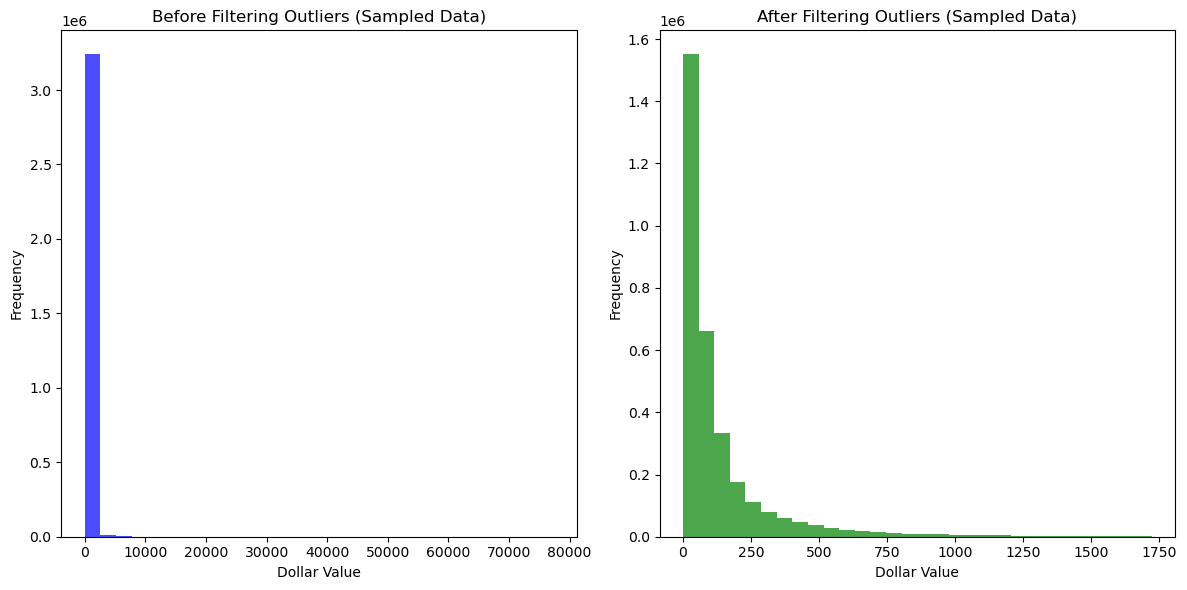

In [58]:
plt.figure(figsize=(12, 6))

# Before filtering outliers (using the sample)
plt.subplot(1, 2, 1)
plt.hist(df_pandas_before['dollar_value'], bins=30, color='blue', alpha=0.7)
plt.title('Before Filtering Outliers (Sampled Data)')
plt.xlabel('Dollar Value')
plt.ylabel('Frequency')

# After filtering outliers (using the sample)
plt.subplot(1, 2, 2)
plt.hist(df_without_outliers['dollar_value'], bins=30, color='green', alpha=0.7)
plt.title('After Filtering Outliers (Sampled Data)')
plt.xlabel('Dollar Value')
plt.ylabel('Frequency')

# Show the plots
plt.tight_layout()
plt.show()


## Export Data to Parquet

In [60]:
filter_outliers.write.parquet("../data/curated/aggregated_data")